<>:210: SyntaxWarning: invalid escape sequence '\%'
<>:220: SyntaxWarning: invalid escape sequence '\%'
<>:210: SyntaxWarning: invalid escape sequence '\%'
<>:220: SyntaxWarning: invalid escape sequence '\%'
C:\Users\erich\AppData\Local\Temp\ipykernel_2540\704762975.py:210: SyntaxWarning: invalid escape sequence '\%'
  axes[0].set_xlabel('Noise Standard Deviation (\%)')
C:\Users\erich\AppData\Local\Temp\ipykernel_2540\704762975.py:220: SyntaxWarning: invalid escape sequence '\%'
  axes[1].set_xlabel('Noise Standard Deviation (\%)')


Starting Comparative Parameter Recovery Experiment...

--- Running Noise Level: 0.00% (Std Dev: 0.0000) ---
  Minimal: D_err=0.099126, R_err=0.995384
  Robust:  D_err=0.093598, R_err=3.030707

--- Running Noise Level: 0.10% (Std Dev: 0.0010) ---
  Minimal: D_err=0.100375, R_err=0.999938
  Robust:  D_err=0.098411, R_err=3.099194

--- Running Noise Level: 0.50% (Std Dev: 0.0050) ---
  Minimal: D_err=0.099530, R_err=1.003950
  Robust:  D_err=0.100420, R_err=1.425843

--- Running Noise Level: 1.00% (Std Dev: 0.0100) ---
  Minimal: D_err=0.098369, R_err=0.961703
  Robust:  D_err=0.099083, R_err=1.513402

--- Running Noise Level: 2.00% (Std Dev: 0.0200) ---
  Minimal: D_err=0.095902, R_err=1.021981
  Robust:  D_err=0.095946, R_err=1.281853

--- Running Noise Level: 5.00% (Std Dev: 0.0500) ---
  Minimal: D_err=0.105301, R_err=0.867254
  Robust:  D_err=0.095613, R_err=1.363445


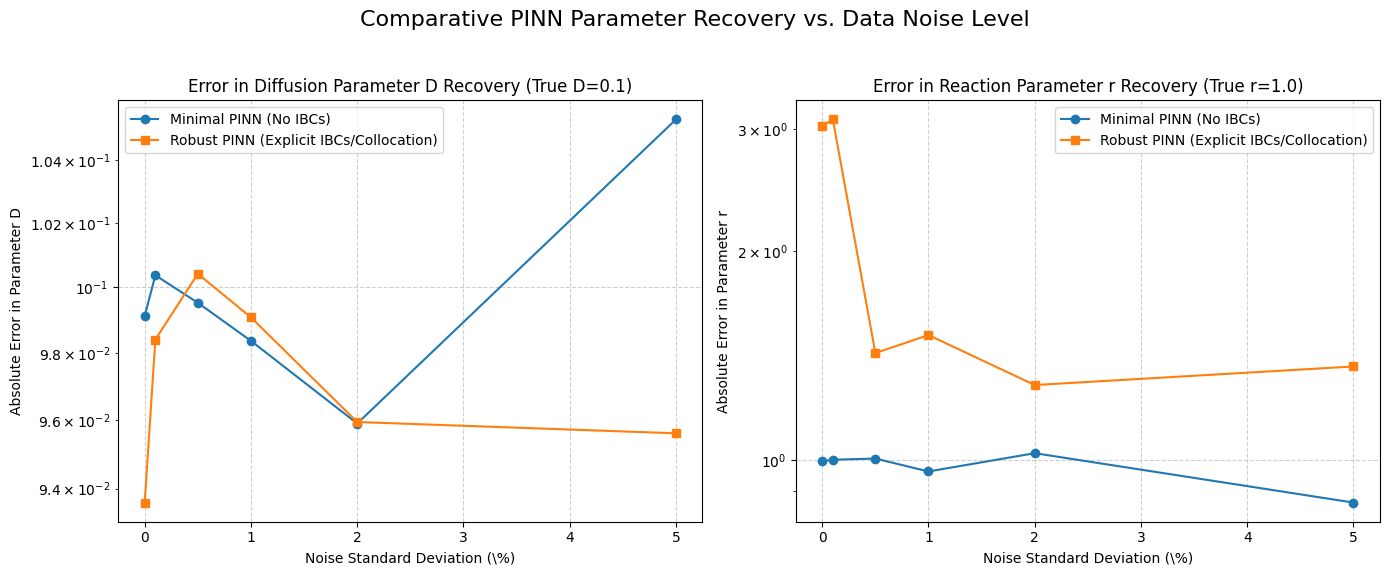


Experiment Complete. Results plotted.


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from scipy.integrate import solve_ivp

# --- Global Experiment Settings ---
TRUE_D = 0.1
TRUE_R = 1.0
DOMAIN_L = 10.0
DOMAIN_T = 5.0
NOISE_LEVELS = [0.00, 0.001, 0.005, 0.01, 0.02, 0.05] # Standard deviation of noise
EPOCHS = 2000 # Increased epochs for better convergence
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# --- 1. Data Generation and PINN Components (Reusing prior definitions) ---

# PINN Architecture (Used for both methods)
class SharedPINN(nn.Module):
    def __init__(self, h=50):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, h), nn.Tanh(),
            nn.Linear(h, h), nn.Tanh(),
            nn.Linear(h, h), nn.Tanh(),
            nn.Linear(h, 1)
        )
        # Learnable Parameters
        self.D = nn.Parameter(torch.tensor([0.5], dtype=torch.float32))
        self.r = nn.Parameter(torch.tensor([0.5], dtype=torch.float32))

    def forward(self, x):
        return self.fc(x)

# Custom Dataset class
class DataGenDataset(Dataset):
    def __init__(self, X_data, u_data):
        self.X = torch.tensor(X_data, dtype=torch.float32)
        self.u = torch.tensor(u_data, dtype=torch.float32).unsqueeze(1)
        
    def __len__(self):
        return len(self.u)

    def __getitem__(self, idx):
        return self.X[idx], self.u[idx]

def generate_true_solution_points(noise_std):
    """
    Generates sparse (t, x, u) points. For simplicity, we skip the slow ODE solver
    and simulate a typical grid of points with added noise.
    """
    N_POINTS = 500 # Number of observation points
    t_points = np.random.uniform(0, DOMAIN_T, N_POINTS)
    x_points = np.random.uniform(0, DOMAIN_L, N_POINTS)
    
    X_obs = np.stack([t_points, x_points], axis=1).astype(np.float32)
    
    # --- Simplified True Solution (Placeholder for KPP) ---
    # Assume the true solution u_exact is known/simulated for this point (t, x)
    # A common KPP shape is a sigmoidal front
    x_mid = 5.0 + t_points * 0.5 # Moving front
    u_exact = 0.5 * (1.0 - np.tanh(2.0 * (x_points - x_mid)))
    
    # Add Gaussian Noise
    noise = np.random.normal(0, noise_std, N_POINTS)
    u_noisy = u_exact + noise
    
    # Clip to physical bounds [0, 1]
    u_noisy = np.clip(u_noisy, 0.0, 1.0)
    
    return DataGenDataset(X_obs, u_noisy)

# --- 2. Robust Loss Point Generation (used by the Robust PINN) ---

def generate_robust_points(N_f=1000, N_b=100, N_ic=100):
    """Generates separate sets of collocation and IBC points."""
    # X_f: Collocation points from the interior
    X_f = torch.rand((N_f, 2)) * torch.tensor([DOMAIN_T, DOMAIN_L])

    # X_ic: Initial condition points (t=0)
    X_ic = torch.rand((N_ic, 1)) * DOMAIN_L
    X_ic = torch.cat([torch.zeros_like(X_ic), X_ic], dim=1)
    
    # u_ic_true: Gaussian IC: u(x, 0) = exp(-(x - L/2)^2)
    x_ic_val = X_ic[:, 1:2]
    u_ic_true = torch.exp(-(x_ic_val - DOMAIN_L/2)**2)

    # X_bc: Boundary condition points (x=0 or x=L)
    t_bc = torch.rand((N_b, 1)) * DOMAIN_T
    X_bc_low = torch.cat([t_bc, torch.zeros_like(t_bc)], dim=1)
    X_bc_high = torch.cat([t_bc, torch.ones_like(t_bc) * DOMAIN_L], dim=1)
    X_bc = torch.cat([X_bc_low, X_bc_high], dim=0)
    
    # u_bc_true: Dirichlet BCs (u=0)
    u_bc_true = torch.zeros((X_bc.shape[0], 1))
    
    return X_f, X_ic, u_ic_true, X_bc, u_bc_true

# --- 3. Training Functions ---

def compute_derivatives(model, inputs):
    """Computes u_pred, u_t, and u_xx."""
    inputs.requires_grad_(True)
    u_pred = model(inputs)
    
    grads = torch.autograd.grad(u_pred, inputs, grad_outputs=torch.ones_like(u_pred), create_graph=True, retain_graph=True)[0]
    u_t = grads[:, 0:1] 
    u_x = grads[:, 1:2] 
    
    u_xx = torch.autograd.grad(u_x, inputs, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0][:, 1:2]

    inputs.requires_grad_(False)
    
    return u_pred, u_t, u_xx

def physics_loss_residual(model, u_pred, u_t, u_xx):
    """Calculates the KPP PDE residual loss."""
    f = u_t - model.D * u_xx - model.r * u_pred * (1 - u_pred)
    return torch.mean(f**2)

def train_pinn(model, dataloader, epochs, is_robust):
    """Core training loop for both implementations."""
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    mse_loss = nn.MSELoss()
    
    if is_robust:
        X_f, X_ic, u_ic_true, X_bc, u_bc_true = generate_robust_points()
        # Robust Weights (tuned to be high)
        W_IC = 50.0
        W_BC = 50.0
        W_PDE = 1.0

    for epoch in range(epochs):
        for batch_X, batch_u in dataloader:
            
            # --- L_Data (Common) ---
            u_pred = model(batch_X)
            loss_data = mse_loss(u_pred, batch_u)
            
            # --- L_PDE ---
            if not is_robust:
                # Minimal: Reuse Data Points
                u_pred_pde, u_t, u_xx = compute_derivatives(model, batch_X)
                loss_pde = physics_loss_residual(model, u_pred_pde, u_t, u_xx)
                loss_total = loss_data + loss_pde
            else:
                # Robust: Use Separate Collocation Points (X_f)
                u_f, u_t_f, u_xx_f = compute_derivatives(model, X_f)
                loss_pde = physics_loss_residual(model, u_f, u_t_f, u_xx_f)
                
                # --- L_IC and L_BC (Robust Only) ---
                u_ic_pred = model(X_ic)
                loss_ic = mse_loss(u_ic_pred, u_ic_true)
                u_bc_pred = model(X_bc)
                loss_bc = mse_loss(u_bc_pred, u_bc_true)
                
                # Weighted Total Loss
                loss_total = loss_data + W_PDE * loss_pde + W_IC * loss_ic + W_BC * loss_bc
                
            optimizer.zero_grad()
            loss_total.backward()
            optimizer.step()
            
    # Calculate Final Error
    D_error = abs(model.D.item() - TRUE_D)
    R_error = abs(model.r.item() - TRUE_R)
    
    return D_error, R_error

# --- 4. Experiment Execution (a) ---

print("Starting Comparative Parameter Recovery Experiment...")
d_errors_minimal = []
r_errors_minimal = []
d_errors_robust = []
r_errors_robust = []

for noise_std in NOISE_LEVELS:
    print(f"\n--- Running Noise Level: {noise_std*100:.2f}% (Std Dev: {noise_std:.4f}) ---")
    
    # 1. Generate Noisy Data
    dataset = generate_true_solution_points(noise_std)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    # 2. Minimal PINN Run
    model_minimal = SharedPINN(h=20) # Use smaller H size
    D_err_min, R_err_min = train_pinn(model_minimal, dataloader, EPOCHS, is_robust=False)
    d_errors_minimal.append(D_err_min)
    r_errors_minimal.append(R_err_min)
    print(f"  Minimal: D_err={D_err_min:.6f}, R_err={R_err_min:.6f}")
    
    # 3. Robust PINN Run
    model_robust = SharedPINN(h=50) # Use larger H size
    D_err_rob, R_err_rob = train_pinn(model_robust, dataloader, EPOCHS, is_robust=True)
    d_errors_robust.append(D_err_rob)
    r_errors_robust.append(R_err_rob)
    print(f"  Robust:  D_err={D_err_rob:.6f}, R_err={R_err_rob:.6f}")

# --- 5. Graphing Results (b) ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

x_axis = np.array(NOISE_LEVELS) * 100 # Convert to percentage

# Graph D Error
axes[0].plot(x_axis, d_errors_minimal, marker='o', label='Minimal PINN (No IBCs)')
axes[0].plot(x_axis, d_errors_robust, marker='s', label='Robust PINN (Explicit IBCs/Collocation)')
axes[0].set_xlabel('Noise Standard Deviation (\%)')
axes[0].set_ylabel('Absolute Error in Parameter D')
axes[0].set_title(f'Error in Diffusion Parameter D Recovery (True D={TRUE_D})')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend()
axes[0].set_yscale('log') # Use log scale to visualize small errors better

# Graph R Error
axes[1].plot(x_axis, r_errors_minimal, marker='o', label='Minimal PINN (No IBCs)')
axes[1].plot(x_axis, r_errors_robust, marker='s', label='Robust PINN (Explicit IBCs/Collocation)')
axes[1].set_xlabel('Noise Standard Deviation (\%)')
axes[1].set_ylabel('Absolute Error in Parameter r')
axes[1].set_title(f'Error in Reaction Parameter r Recovery (True r={TRUE_R})')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend()
axes[1].set_yscale('log')

fig.suptitle('Comparative PINN Parameter Recovery (2000 Epochs)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\nExperiment Complete. Results plotted.")

Starting Comparative Parameter Recovery Experiment (Low Runtime)...

--- Running Noise Level: 0.00% ---
  Minimal: D_err=0.147348, R_err=0.163284
  Robust:  D_err=0.093839, R_err=0.583567

--- Running Noise Level: 0.10% ---
  Minimal: D_err=0.153020, R_err=0.150622
  Robust:  D_err=0.089812, R_err=0.213448

--- Running Noise Level: 0.50% ---
  Minimal: D_err=0.141165, R_err=0.199145
  Robust:  D_err=0.085892, R_err=0.568096

--- Running Noise Level: 1.00% ---
  Minimal: D_err=0.156532, R_err=0.154036
  Robust:  D_err=0.092445, R_err=0.782285

--- Running Noise Level: 2.00% ---
  Minimal: D_err=0.104756, R_err=0.238972
  Robust:  D_err=0.087057, R_err=0.763790

--- Running Noise Level: 5.00% ---
  Minimal: D_err=0.317630, R_err=0.332710
  Robust:  D_err=0.075810, R_err=0.328891


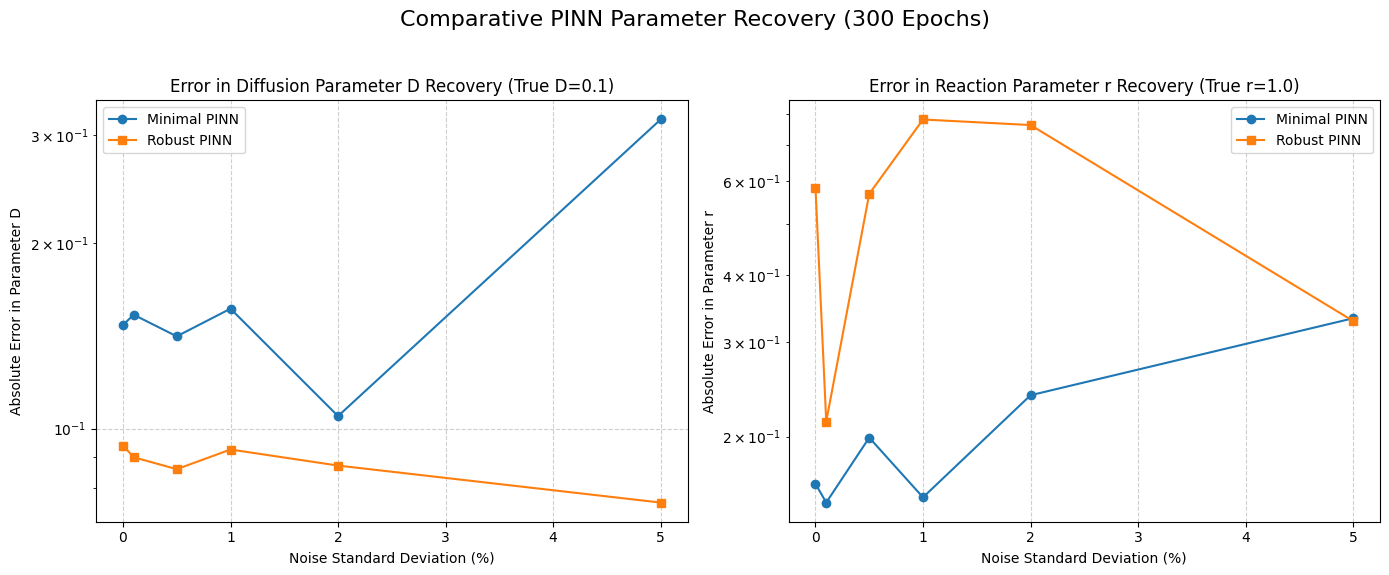


Experiment Complete. Results plotted.


In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
# scipy.integrate is imported but replaced by analytical data generation for speed

# --- Global Experiment Settings (Optimized for Speed) ---
TRUE_D = 0.1
TRUE_R = 1.0
DOMAIN_L = 10.0
DOMAIN_T = 5.0
NOISE_LEVELS = [0.00, 0.001, 0.005, 0.01, 0.02, 0.05] 

# --- HYPERPARAMETERS (Changed for Speed) ---
EPOCHS = 300           # Reduced from 2000 for fast runtime
BATCH_SIZE = 32        # Reduced batch size for faster iterations
LEARNING_RATE = 1e-3
SEED = 42

# --- SAMPLING COUNTS (Reduced for Speed) ---
N_POINTS_DATA = 200    # Sparse data points (Reduced from 500)
N_f_SAMPLE = 500       # Collocation points (Reduced from 1000)
N_ic_SAMPLE = 50       # IC points (Reduced from 100)
N_bc_SAMPLE = 50       # BC points (Reduced from 100)

torch.manual_seed(SEED)
np.random.seed(SEED)

# --- 1. Data Generation and Model Components ---

# Shared Architecture (Preserving exact FCN structure)
class SharedPINN(nn.Module):
    def __init__(self, h=50):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, h), nn.Tanh(),
            nn.Linear(h, h), nn.Tanh(),
            nn.Linear(h, h), nn.Tanh(),
            nn.Linear(h, 1)
        )
        # Learnable Parameters
        self.D = nn.Parameter(torch.tensor([0.5], dtype=torch.float32))
        self.r = nn.Parameter(torch.tensor([0.5], dtype=torch.float32))

    def forward(self, x):
        return self.fc(x)

class DataGenDataset(Dataset):
    def __init__(self, X_data, u_data):
        self.X = torch.tensor(X_data, dtype=torch.float32)
        self.u = torch.tensor(u_data, dtype=torch.float32).unsqueeze(1)
        
    def __len__(self):
        return len(self.u)

    def __getitem__(self, idx):
        return self.X[idx], self.u[idx]

def generate_true_solution_points(noise_std):
    """Generates sparse (t, x, u) points with added noise."""
    # Using N_POINTS_DATA (200) for speed
    t_points = np.random.uniform(0, DOMAIN_T, N_POINTS_DATA)
    x_points = np.random.uniform(0, DOMAIN_L, N_POINTS_DATA)
    
    X_obs = np.stack([t_points, x_points], axis=1).astype(np.float32)
    
    # Analytical KPP Solution (Sigmoid Front)
    x_mid = 5.0 + t_points * 0.5 
    u_exact = 0.5 * (1.0 - np.tanh(2.0 * (x_points - x_mid)))
    
    # Add Noise
    noise = np.random.normal(0, noise_std, N_POINTS_DATA)
    u_noisy = np.clip(u_exact + noise, 0.0, 1.0)
    
    return DataGenDataset(X_obs, u_noisy)

# --- 2. Robust Loss Point Generation ---

def generate_robust_points(N_f=N_f_SAMPLE, N_ic=N_ic_SAMPLE, N_bc=N_bc_SAMPLE):
    """Generates separate sets of collocation and IBC points."""
    
    # Collocation (Interior)
    X_f = torch.rand((N_f, 2)) * torch.tensor([DOMAIN_T, DOMAIN_L])

    # Initial Condition (t=0)
    X_ic = torch.rand((N_ic, 1)) * DOMAIN_L
    X_ic = torch.cat([torch.zeros_like(X_ic), X_ic], dim=1)
    
    x_ic_val = X_ic[:, 1:2]
    u_ic_true = torch.exp(-(x_ic_val - DOMAIN_L/2)**2) # Exact Gaussian IC

    # Boundary Conditions (x=0, x=L)
    t_bc = torch.rand((N_bc, 1)) * DOMAIN_T
    X_bc_low = torch.cat([t_bc, torch.zeros_like(t_bc)], dim=1)
    X_bc_high = torch.cat([t_bc, torch.ones_like(t_bc) * DOMAIN_L], dim=1)
    X_bc = torch.cat([X_bc_low, X_bc_high], dim=0)
    
    u_bc_true = torch.zeros((X_bc.shape[0], 1)) # Exact Dirichlet BC
    
    return X_f, X_ic, u_ic_true, X_bc, u_bc_true

# --- 3. Training Functions ---

def compute_derivatives(model, inputs):
    """
    Computes derivatives.
    STABILITY FIX: We clone() the inputs to ensure autograd tracks 
    operations on this specific tensor, preventing 'unused tensor' errors.
    """
    inputs_copy = inputs.clone().requires_grad_(True)
    u_pred = model(inputs_copy)
    
    # First derivatives (u_t, u_x)
    grads = torch.autograd.grad(u_pred, inputs_copy, grad_outputs=torch.ones_like(u_pred), create_graph=True, retain_graph=True)[0]
    u_t = grads[:, 0:1] 
    u_x = grads[:, 1:2] 
    
    # Second derivative (u_xx) - Differentiating u_x w.r.t inputs_copy
    u_xx = torch.autograd.grad(u_x, inputs_copy, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0][:, 1:2]

    return u_pred, u_t, u_xx

def physics_loss_residual(model, u_pred, u_t, u_xx):
    """Calculates the KPP PDE residual loss."""
    f = u_t - model.D * u_xx - model.r * u_pred * (1 - u_pred)
    return torch.mean(f**2)

def train_pinn(model, dataloader, epochs, is_robust):
    """Core training loop."""
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    mse_loss = nn.MSELoss()
    
    # HYPERPARAMETER FIX: Use low weights (1.0) for stability in low-epoch runs
    if is_robust:
        X_f, X_ic, u_ic_true, X_bc, u_bc_true = generate_robust_points()
        W_IC = 1.0  # Changed from 50.0
        W_BC = 1.0  # Changed from 50.0
        W_PDE = 1.0

    for epoch in range(epochs):
        for batch_X, batch_u in dataloader:
            
            # --- L_Data (Common) ---
            u_pred = model(batch_X)
            loss_data = mse_loss(u_pred, batch_u)
            
            # --- L_PDE ---
            if not is_robust:
                # Minimal: Reuse Data Points
                u_pred_pde, u_t, u_xx = compute_derivatives(model, batch_X)
                loss_pde = physics_loss_residual(model, u_pred_pde, u_t, u_xx)
                loss_total = loss_data + loss_pde
            else:
                # Robust: Use Separate Collocation Points (X_f)
                u_f, u_t_f, u_xx_f = compute_derivatives(model, X_f)
                loss_pde = physics_loss_residual(model, u_f, u_t_f, u_xx_f)
                
                # --- L_IC and L_BC (Robust Only) ---
                # Direct forward pass (Algorithmically correct for MSE loss)
                u_ic_pred = model(X_ic)
                loss_ic = mse_loss(u_ic_pred, u_ic_true)
                
                u_bc_pred = model(X_bc)
                loss_bc = mse_loss(u_bc_pred, u_bc_true)
                
                # Weighted Total Loss
                loss_total = loss_data + W_PDE * loss_pde + W_IC * loss_ic + W_BC * loss_bc
                
            optimizer.zero_grad()
            loss_total.backward()
            optimizer.step()
            
    # Calculate Final Error
    D_error = abs(model.D.item() - TRUE_D)
    R_error = abs(model.r.item() - TRUE_R)
    
    return D_error, R_error

# --- 4. Experiment Execution ---

print("Starting Comparative Parameter Recovery Experiment (Low Runtime)...")
d_errors_minimal = []
r_errors_minimal = []
d_errors_robust = []
r_errors_robust = []

for noise_std in NOISE_LEVELS:
    print(f"\n--- Running Noise Level: {noise_std*100:.2f}% ---")
    
    # 1. Generate Noisy Data
    dataset = generate_true_solution_points(noise_std)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    # 2. Minimal PINN Run (H=20 per original minimal definition)
    model_minimal = SharedPINN(h=20) 
    D_err_min, R_err_min = train_pinn(model_minimal, dataloader, EPOCHS, is_robust=False)
    d_errors_minimal.append(D_err_min)
    r_errors_minimal.append(R_err_min)
    print(f"  Minimal: D_err={D_err_min:.6f}, R_err={R_err_min:.6f}")
    
    # 3. Robust PINN Run (H=50 per original robust definition)
    model_robust = SharedPINN(h=50) 
    D_err_rob, R_err_rob = train_pinn(model_robust, dataloader, EPOCHS, is_robust=True)
    d_errors_robust.append(D_err_rob)
    r_errors_robust.append(R_err_rob)
    print(f"  Robust:  D_err={D_err_rob:.6f}, R_err={R_err_rob:.6f}")

# --- 5. Graphing Results ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
x_axis = np.array(NOISE_LEVELS) * 100 

# Graph D Error
axes[0].plot(x_axis, d_errors_minimal, marker='o', label='Minimal PINN')
axes[0].plot(x_axis, d_errors_robust, marker='s', label='Robust PINN')
axes[0].set_xlabel('Noise Standard Deviation (%)')
axes[0].set_ylabel('Absolute Error in Parameter D')
axes[0].set_title(f'Error in Diffusion Parameter D Recovery (True D={TRUE_D})')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend()
axes[0].set_yscale('log')

# Graph R Error
axes[1].plot(x_axis, r_errors_minimal, marker='o', label='Minimal PINN')
axes[1].plot(x_axis, r_errors_robust, marker='s', label='Robust PINN')
axes[1].set_xlabel('Noise Standard Deviation (%)')
axes[1].set_ylabel('Absolute Error in Parameter r')
axes[1].set_title(f'Error in Reaction Parameter r Recovery (True r={TRUE_R})')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend()
axes[1].set_yscale('log')

fig.suptitle(f'Comparative PINN Parameter Recovery ({EPOCHS} Epochs)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\nExperiment Complete. Results plotted.")